# SAS Risk Engine on Python: A Primer

By Joshua Johnstone and Dave Stonehouse

## What's to come
In this demonstration, we'll run a Monte Carlo simulation of market risk factors, and evaluate a portfolio of bonds. We will query the results for a variety of risk metrics, slicing and dicing the portfolio and aggregating statistics on the fly.
* Import packages
* Connect to CAS
* Using objects in RiskPy:
    * Market Data
    * Market States
    * Portfolio
    * Method Library
    * Values
    * Results
* Creating a simple report
* Plotting density curves with Seaborn and MatPlotLib

## Import Packages
Let's import RiskPy and SWAT, and some other helpful packages to get started.

In [1]:
import riskpy
import swat

import pandas as pd
import datetime as dt
import seaborn  as sns
import matplotlib.pyplot as plt

## Connect to CAS
The SessionContext object lets other objects know about our connection to CAS, as well as a default CASLIB for writing tables.

In [2]:
session = swat.CAS()
caslib  = "CASUSER"
conn    = riskpy.SessionContext(session=session, caslib=caslib)

## Object: Market Data
MarketData objects contain pointers to economic data, and describe risk factors for our analysis.

In [3]:
market_data = riskpy.MarketData(
        current    = 'datasources/MarketRisk/current.xlsx', 
        historical = 'datasources/MarketRisk/history.xlsx')

In [4]:
# View current market data
pd.read_excel(market_data.current).head()

,zero_rt,creditspread_rt
0,0.024,0.01012


c:\users\daston\appdata\local\programs\python\python36\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Risk Factor Historical Time Series')

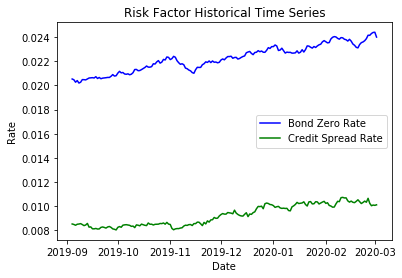

In [5]:
# Plot historical market data
hist_df = pd.read_excel(market_data.historical)

plt.plot(hist_df['date'], hist_df['zero_rt'], color='blue')
plt.plot(hist_df['date'], hist_df['creditspread_rt'], color='green')

plt.legend(labels=['Bond Zero Rate', 'Credit Spread Rate'])
plt.xlabel('Date')
plt.ylabel('Rate')
plt.title('Risk Factor Historical Time Series')

## Object: Market States
With a MarketStates object, we can set up a simulation...

In [6]:
market_states = riskpy.MarketStates(
        market_data       = market_data,
        as_of_date        = dt.datetime(2020,3,2),
        num_horizons      = 10,
        num_draws         = 500,
        session_context   = conn)

...and run it with a simple function call to generate market states.

In [7]:
market_states.generate()

NOTE: Executing action 'table.loadTable'.
NOTE: Cloud Analytic Services made the uploaded file available as table MARKETDATA_CURRENT in caslib CASUSER(daston).
NOTE: Action 'table.loadTable' used (Total process time):
NOTE:       real time               0.101875 seconds
NOTE:       cpu time                0.209969 seconds (206.10%)
NOTE:       data movement time      0.003940 seconds
NOTE:       total nodes             3 (48 cores)
NOTE:       total memory            756.70G
NOTE:       memory                  35.10M (0.00%)
NOTE:       bytes moved             0.19K
NOTE: The table MARKETDATA_CURRENT has been created in caslib CASUSER(daston) from binary data uploaded to Cloud Analytic Services.
NOTE: Action 'table.upload' used (Total process time):
NOTE:       real time               0.122133 seconds
NOTE:       cpu time                0.246963 seconds (202.21%)
NOTE:       total nodes             3 (48 cores)
NOTE:       total memory            756.70G
NOTE:       memory             

Many actions create SWAT CASTable objects, which can be treated much like Pandas DataFrames:

In [8]:
market_states.states.head()

,_rep_,_date_,_horidx_,zero_rt,creditspread_rt
0,1.0,2020-03-03,1.0,0.024651,0.010245
1,1.0,2020-03-04,2.0,0.024598,0.010165
2,1.0,2020-03-05,3.0,0.024533,0.010062
3,1.0,2020-03-06,4.0,0.024642,0.010112
4,1.0,2020-03-09,5.0,0.024682,0.010066


Text(0.5, 1.0, 'Simulated Risk Factor Values')

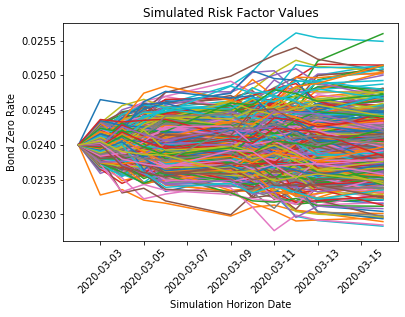

In [9]:
states_df = market_states.states.to_frame()
states_df['_rep_'] = states_df['_rep_'].astype(int)

for rep in range(1, market_states.num_draws):
    if rep == 1:
        x = states_df[states_df['_rep_'] == rep]['_date_']
        x = pd.concat([pd.Series([market_states.as_of_date]), x])
    y = states_df[states_df['_rep_'] == rep]['zero_rt']
    y = pd.concat([pd.Series([0.024]), y])
    plt.plot(x, y)
    
plt.xticks(rotation=45)
plt.xlabel('Simulation Horizon Date')
plt.ylabel('Bond Zero Rate')
plt.title('Simulated Risk Factor Values')


## Object: Portfolio
A Portfolio object contains an instrument data source and cross-classification variables:

In [10]:
portfolio = riskpy.Portfolio(
        data = 'datasources/MarketRisk/portfolio.xlsx',
        class_variables = ['Desk', 'Region', 'insttype'])

In [11]:
portfolio.upload(session_context=conn)
portfolio.castable.head()

NOTE: Executing action 'table.loadTable'.
NOTE: Cloud Analytic Services made the uploaded file available as table PORTFOLIO in caslib CASUSER(daston).
NOTE: Action 'table.loadTable' used (Total process time):
NOTE:       real time               0.174509 seconds
NOTE:       cpu time                0.355946 seconds (203.97%)
NOTE:       data movement time      0.004366 seconds
NOTE:       total nodes             3 (48 cores)
NOTE:       total memory            756.70G
NOTE:       memory                  67.32M (0.01%)
NOTE:       bytes moved             101.30K
NOTE: The table PORTFOLIO has been created in caslib CASUSER(daston) from binary data uploaded to Cloud Analytic Services.
NOTE: Action 'table.upload' used (Total process time):
NOTE:       real time               0.195218 seconds
NOTE:       cpu time                0.394939 seconds (202.31%)
NOTE:       total nodes             3 (48 cores)
NOTE:       total memory            756.70G
NOTE:       memory                  67.32M (0.0

,instid,insttype,region,desk,face_value,maturity_dt
0,inst00001,CorporateBond,East,A,29519.0,25185.0
1,inst00002,TBond,South,B,21685.0,23639.0
2,inst00003,TBond,East,B,28369.0,24993.0
3,inst00004,CorporateBond,South,C,9960.2,22780.0
4,inst00005,CorporateBond,West,C,89014.0,24574.0


## Object: Method Library
The MethodLib object points out to a code file containing pricing or evaluation methods for the analysis.

In [12]:
methods = riskpy.MethodLib(method_code='methods/bond_methods.sas')

## Object: Values
Values connects together many of the other RiskPy objects in order to evaluate the portfolio. Here, we also associate instrument types with pricing methods using the 'mapping' attribute.

In [13]:
values = riskpy.Values(
        session_context  = conn,
        portfolio        = portfolio,
        market_states    = market_states,
        method_lib       = methods,
        mapping          = {"CorporateBond":"corporate_bond", "TBond":"treasury_bond"})


If you have graphviz installed, you can display a graphical view of the system:

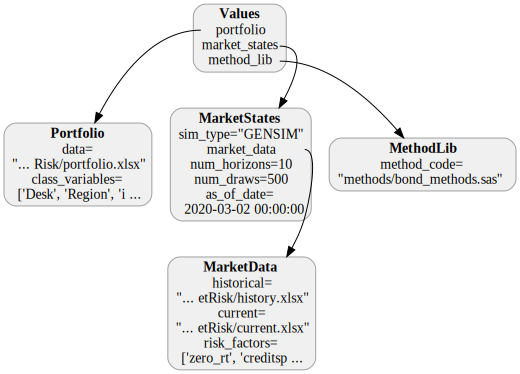

In [14]:
values

Now, evaluating the portfolio is as easy as calling a function. We specify write_prices=True to create a table of prices (called "allprice") for the positions in the portfolio at all market states and horizons. 

In [15]:
values.evaluate(write_prices=True)

NOTE: Executing action 'table.loadTable'.
NOTE: Cloud Analytic Services made the uploaded file available as table MARKETDATA_CURRENT in caslib CASUSER(daston).
NOTE: Action 'table.loadTable' used (Total process time):
NOTE:       real time               0.092712 seconds
NOTE:       cpu time                0.203968 seconds (220.00%)
NOTE:       data movement time      0.002695 seconds
NOTE:       total nodes             3 (48 cores)
NOTE:       total memory            756.70G
NOTE:       memory                  35.05M (0.00%)
NOTE:       bytes moved             0.19K
NOTE: The table MARKETDATA_CURRENT has been created in caslib CASUSER(daston) from binary data uploaded to Cloud Analytic Services.
NOTE: Action 'table.upload' used (Total process time):
NOTE:       real time               0.110697 seconds
NOTE:       cpu time                0.236964 seconds (214.07%)
NOTE:       total nodes             3 (48 cores)
NOTE:       total memory            756.70G
NOTE:       memory             

In [16]:
values.allprice.head()

,AnalysisName,_horidx_,_rep_,_date_,FX_Rate,instid,Value
0,BASECASE,NaN,NaN,2020-03-02,1.0,inst00001,21868.747486
1,,1.0,1.0,2020-03-03,1.0,inst00001,21722.278563
2,,1.0,2.0,2020-03-03,1.0,inst00001,22047.770580
3,,1.0,3.0,2020-03-03,1.0,inst00001,21951.228320
4,,1.0,4.0,2020-03-03,1.0,inst00001,21936.004012


## Object: Results
By configuring the Results object, we can query for prices, statistics, and densities. The flexibility of this object allows us to slice and dice the results any way we like.

In [17]:
results = riskpy.Results(
    values=values, 
    session_context=conn)

### Default: All statistics
By default, a query returns all statistics, for all output variables, at all horizons, aggregated to the top level of the portfolio.

In [18]:
query = results.query()

NOTE: Executing action 'builtins.loadActionSet'.
NOTE: Added action set 'riskresults'.
NOTE: Action 'builtins.loadActionSet' used (Total process time):
NOTE:       real time               0.010483 seconds
NOTE:       cpu time                0.020996 seconds (200.29%)
NOTE:       total nodes             3 (48 cores)
NOTE:       total memory            756.70G
NOTE:       memory                  656.16K (0.00%)
NOTE: Executing action 'riskResults.query'.
NOTE: Starting the query action.
NOTE: The table 'Results_stat' in caslib 'CASUSER(daston)' has 20 observations and 42 variables.
NOTE: Action 'riskResults.query' used (Total process time):
NOTE:       real time               1.643500 seconds
NOTE:       cpu time                14.305826 seconds (870.45%)
NOTE:       data movement time      0.013903 seconds
NOTE:       total nodes             3 (48 cores)
NOTE:       total memory            756.70G
NOTE:       memory                  105.85M (0.01%)
NOTE:       bytes moved             21

In [19]:
query.head()

,NInst,alpha,OutputVariable,_horizon_,_date_,_horidx_,ResultName,BASECASEVALUE,NREPS,N,...,ESWO,INCES,CONTVAR,CONTES,CE,PFE,EE,EEE,EPE,EEPE
0,1000.0,0.05,Value,1.0,2020-03-03,1.0,,4.485755e+07,500.0,500.0,...,0.0,4.480594e+07,4.481986e+07,4.480594e+07,NaN,NaN,NaN,NaN,NaN,NaN
1,1000.0,0.05,Value,2.0,2020-03-04,2.0,,4.485755e+07,500.0,500.0,...,0.0,4.478909e+07,4.480324e+07,4.478909e+07,NaN,NaN,NaN,NaN,NaN,NaN
2,1000.0,0.05,Value,3.0,2020-03-05,3.0,,4.485755e+07,500.0,500.0,...,0.0,4.476936e+07,4.479015e+07,4.476936e+07,NaN,NaN,NaN,NaN,NaN,NaN
3,1000.0,0.05,Value,4.0,2020-03-06,4.0,,4.485755e+07,500.0,500.0,...,0.0,4.475987e+07,4.478496e+07,4.475987e+07,NaN,NaN,NaN,NaN,NaN,NaN
4,1000.0,0.05,Value,5.0,2020-03-09,5.0,,4.485755e+07,500.0,500.0,...,0.0,4.475724e+07,4.478150e+07,4.475724e+07,NaN,NaN,NaN,NaN,NaN,NaN


### Filter by statistic, horizon, and output variable

Let's narrow down the data by configuring attributes of the Results object:

In [20]:
results.statistics = ['VAR', 'ES']
results.horizons = 1
results.outvars = 'PL'

query = results.query()

NOTE: Executing action 'builtins.loadActionSet'.
NOTE: Added action set 'riskresults'.
NOTE: Action 'builtins.loadActionSet' used (Total process time):
NOTE:       real time               0.006916 seconds
NOTE:       cpu time                0.011999 seconds (173.50%)
NOTE:       total nodes             3 (48 cores)
NOTE:       total memory            756.70G
NOTE:       memory                  652.97K (0.00%)
NOTE: Executing action 'riskResults.query'.
NOTE: Starting the query action.
NOTE: The table 'Results_stat' in caslib 'CASUSER(daston)' has 1 observations and 9 variables.
NOTE: Action 'riskResults.query' used (Total process time):
NOTE:       real time               0.943857 seconds
NOTE:       cpu time                8.056775 seconds (853.60%)
NOTE:       data movement time      0.014190 seconds
NOTE:       total nodes             3 (48 cores)
NOTE:       total memory            756.70G
NOTE:       memory                  101.75M (0.01%)
NOTE:       bytes moved             209.0

In [21]:
query.head()

,NInst,alpha,OutputVariable,_horizon_,_date_,_horidx_,ResultName,VAR,ES
0,1000.0,0.05,PL,1.0,2020-03-03,1.0,,37692.906226,51617.666695


### Slice and dice by cross-classification variable

We can specify the levels of aggregation using the 'requests' attribute.

We can filter out positions using cross-class filters. In this example, we only keep positions of type 'CorporateBond,' and drop positions belonging to Desks B and C.

In [22]:
results.requests = [ '_TOP_', 'Desk', ['Desk','Region'], ['Desk','Region','insttype'] ]

results.filters = [{'crossClass':'insttype', 'keep':'CorporateBond'},
                   {'crossClass':'Desk', 'drop':['B','C']}]

query = results.query()

NOTE: Executing action 'builtins.loadActionSet'.
NOTE: Added action set 'riskresults'.
NOTE: Action 'builtins.loadActionSet' used (Total process time):
NOTE:       real time               0.006885 seconds
NOTE:       cpu time                0.012997 seconds (188.77%)
NOTE:       total nodes             3 (48 cores)
NOTE:       total memory            756.70G
NOTE:       memory                  652.97K (0.00%)
NOTE: Executing action 'riskResults.query'.
NOTE: Starting the query action.
NOTE: The table 'Results_stat' in caslib 'CASUSER(daston)' has 10 observations and 12 variables.
NOTE: Action 'riskResults.query' used (Total process time):
NOTE:       real time               1.636074 seconds
NOTE:       cpu time                5.899102 seconds (360.56%)
NOTE:       data movement time      0.014310 seconds
NOTE:       total nodes             3 (48 cores)
NOTE:       total memory            756.70G
NOTE:       memory                  491.81M (0.06%)
NOTE:       bytes moved             211

Let's view the results:

In [23]:
query.head(10)

,Desk,Region,insttype,NInst,alpha,OutputVariable,_horizon_,_date_,_horidx_,ResultName,VAR,ES
0,A,East,CorporateBond,42.0,0.05,PL,1.0,2020-03-03,1.0,,2374.657686,3009.657376
1,A,East,+,42.0,0.05,PL,1.0,2020-03-03,1.0,,2374.657686,3009.657376
2,A,+,+,159.0,0.05,PL,1.0,2020-03-03,1.0,,8460.807347,10724.376349
3,+,+,+,159.0,0.05,PL,1.0,2020-03-03,1.0,,8460.807347,10724.376349
4,A,South,CorporateBond,40.0,0.05,PL,1.0,2020-03-03,1.0,,2026.101150,2570.221270
5,A,South,+,40.0,0.05,PL,1.0,2020-03-03,1.0,,2026.101150,2570.221270
6,A,North,CorporateBond,39.0,0.05,PL,1.0,2020-03-03,1.0,,1965.318257,2491.578886
7,A,North,+,39.0,0.05,PL,1.0,2020-03-03,1.0,,1965.318257,2491.578886
8,A,West,CorporateBond,38.0,0.05,PL,1.0,2020-03-03,1.0,,2094.730254,2652.918817
9,A,West,+,38.0,0.05,PL,1.0,2020-03-03,1.0,,2094.730254,2652.918817


### Change confidence interval for statistics

In [24]:
results.alpha = 0.01
query = results.query()

NOTE: Executing action 'builtins.loadActionSet'.
NOTE: Added action set 'riskresults'.
NOTE: Action 'builtins.loadActionSet' used (Total process time):
NOTE:       real time               0.007753 seconds
NOTE:       cpu time                0.013998 seconds (180.55%)
NOTE:       total nodes             3 (48 cores)
NOTE:       total memory            756.70G
NOTE:       memory                  647.91K (0.00%)
NOTE: Executing action 'riskResults.query'.
NOTE: Starting the query action.
NOTE: The table 'Results_stat' in caslib 'CASUSER(daston)' has 10 observations and 12 variables.
NOTE: Action 'riskResults.query' used (Total process time):
NOTE:       real time               1.988808 seconds
NOTE:       cpu time                6.337037 seconds (318.63%)
NOTE:       data movement time      0.013118 seconds
NOTE:       total nodes             3 (48 cores)
NOTE:       total memory            756.70G
NOTE:       memory                  491.78M (0.06%)
NOTE:       bytes moved             211

In [25]:
query.head(10)

,Desk,Region,insttype,NInst,alpha,OutputVariable,_horizon_,_date_,_horidx_,ResultName,VAR,ES
0,A,South,CorporateBond,40.0,0.01,PL,1.0,2020-03-03,1.0,,2934.236864,3663.040458
1,A,South,+,40.0,0.01,PL,1.0,2020-03-03,1.0,,2934.236864,3663.040458
2,A,+,+,159.0,0.01,PL,1.0,2020-03-03,1.0,,12238.721206,15270.492532
3,+,+,+,159.0,0.01,PL,1.0,2020-03-03,1.0,,12238.721206,15270.492532
4,A,East,CorporateBond,42.0,0.01,PL,1.0,2020-03-03,1.0,,3434.499413,4284.903149
5,A,East,+,42.0,0.01,PL,1.0,2020-03-03,1.0,,3434.499413,4284.903149
6,A,North,CorporateBond,39.0,0.01,PL,1.0,2020-03-03,1.0,,2843.649893,3548.517079
7,A,North,+,39.0,0.01,PL,1.0,2020-03-03,1.0,,2843.649893,3548.517079
8,A,West,CorporateBond,38.0,0.01,PL,1.0,2020-03-03,1.0,,3026.335035,3774.031847
9,A,West,+,38.0,0.01,PL,1.0,2020-03-03,1.0,,3026.335035,3774.031847


We can easily send our results to Excel for further analysis:

In [26]:
query.to_excel('stats.xlsx')

### Query for values instead of statistics

In [27]:
results.out_type = 'values'
results.requests = ['_TOP_']
results.filters  = None

query = results.query(max_rows=500)

loss = -1 * query['PL'] # For plotting later

NOTE: Executing action 'builtins.loadActionSet'.
NOTE: Added action set 'riskresults'.
NOTE: Action 'builtins.loadActionSet' used (Total process time):
NOTE:       real time               0.007238 seconds
NOTE:       cpu time                0.012998 seconds (179.58%)
NOTE:       total nodes             3 (48 cores)
NOTE:       total memory            756.70G
NOTE:       memory                  653.06K (0.00%)
NOTE: Executing action 'riskResults.query'.
NOTE: Starting the query action.
NOTE: The table 'Results_values' in caslib 'CASUSER(daston)' has 500 observations and 7 variables.
NOTE: Action 'riskResults.query' used (Total process time):
NOTE:       real time               0.939789 seconds
NOTE:       cpu time                8.027780 seconds (854.21%)
NOTE:       data movement time      0.014394 seconds
NOTE:       total nodes             3 (48 cores)
NOTE:       total memory            756.70G
NOTE:       memory                  101.75M (0.01%)
NOTE:       bytes moved             2

In [28]:
query.head()

,NInst,ResultName,_date_,_horizon_,_horidx_,_rep_,PL
0,1000.0,,2020-03-03,1.0,1.0,1.0,-117774.202127
1,1000.0,,2020-03-03,1.0,1.0,2.0,143206.767074
2,1000.0,,2020-03-03,1.0,1.0,3.0,59383.947497
3,1000.0,,2020-03-03,1.0,1.0,4.0,48471.201559
4,1000.0,,2020-03-03,1.0,1.0,5.0,40819.776270


## Create Report: Value-at-Risk and Expected Shortfall

Let's create a report showing portfolio VaR and ES at various confidence intervals.

As before, we start by configuring the Results object:

In [29]:
results = riskpy.Results(
    values          = values, 
    session_context = conn,
    horizons        = 1,
    statistics      = ['VAR', 'ES'],
    outvars         = 'PL')

Now, we simply run a few queries with different alphas, and append them all together:

In [30]:
results.alpha = 0.05
query1 = results.query().to_frame()

results.alpha = 0.01
query2 = results.query().to_frame()

results.alpha = 0.005
query3 = results.query().to_frame()

report = query1.append([query2, query3])

NOTE: Executing action 'builtins.loadActionSet'.
NOTE: Added action set 'riskresults'.
NOTE: Action 'builtins.loadActionSet' used (Total process time):
NOTE:       real time               0.006646 seconds
NOTE:       cpu time                0.013997 seconds (210.61%)
NOTE:       total nodes             3 (48 cores)
NOTE:       total memory            756.70G
NOTE:       memory                  653.06K (0.00%)
NOTE: Executing action 'riskResults.query'.
NOTE: Starting the query action.
NOTE: The table 'Results_stat' in caslib 'CASUSER(daston)' has 1 observations and 9 variables.
NOTE: Action 'riskResults.query' used (Total process time):
NOTE:       real time               0.926772 seconds
NOTE:       cpu time                8.015781 seconds (864.91%)
NOTE:       data movement time      0.014094 seconds
NOTE:       total nodes             3 (48 cores)
NOTE:       total memory            756.70G
NOTE:       memory                  102.07M (0.01%)
NOTE:       bytes moved             209.0

In [31]:
report

,NInst,alpha,OutputVariable,_horizon_,_date_,_horidx_,ResultName,VAR,ES
0,1000.0,0.050,PL,1.0,2020-03-03,1.0,,37692.906226,51617.666695
0,1000.0,0.010,PL,1.0,2020-03-03,1.0,,60292.934250,79566.427339
0,1000.0,0.005,PL,1.0,2020-03-03,1.0,,68315.229741,94234.975556


## Plot using well-known Python packages

Text(0.5, 1.0, 'Histogram and Density Plot of Loss Distribution')

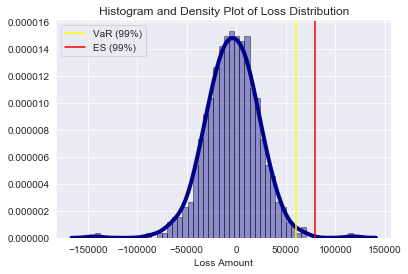

In [32]:
sns.set_style("darkgrid")
sns.distplot(loss, hist=True, kde=True, bins=50, color='darkblue', axlabel="Loss Amount",
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
varline = plt.axvline(query2['VAR'][0], color='yellow')
esline  = plt.axvline(query2['ES'][0],  color='red')
plt.legend(handles=[varline, esline], labels=["VaR (99%)", "ES (99%)"])
plt.title("Histogram and Density Plot of Loss Distribution")